<a href="https://colab.research.google.com/github/mehdihatami1998/DynamicsOfStructures/blob/main/L12_Exact_Integration_for_EP_SDOF_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib.pyplot import figure, plot, rcParams, style, title, xlabel, ylabel
from numpy import cos, exp, linspace, pi, sqrt, sin, where

style.use(['fivethirtyeight'])

rcParams['figure.figsize'] = [14, 4.5]
rcParams['axes.labelsize'] = 'x-large'
rcParams['xtick.labelsize']  = 'large'
rcParams['ytick.labelsize']  = 'large'
rcParams['figure.facecolor'] = 'FCFFFF'

# Exact Integration for an EP SDOF System

We want to compute the response of an Elasto Plastic (EP)
system, using the constant acceleration algorithm and the Modified Newton-Raphson (MNR, or NR)

But how we can confirm or reject our results?

It turns out that computing the exact response of an EP system with 
a single degree of freedom is relatively simple.

In this section, we write a program that computes the analytical solution of our problem.

The main building blocks of the program will be two functions
that compute, for the elastic phase and for the plastic phase,
the analytical functions that give the displacement and the
velocity as functions of time.

## Elastic response

We are definining a function that, for a linear dynamic system,
returns not the displacement or the velocity at a given time,
but rather a couple of functions of time that we can use afterwards
to compute displacements and velecities at any time of interest.

The response depends on the parameters of the dynamic system $m,c,k,$
on the initial conditions $x_0, v_0,$ and on the characteristics of the external load.

Here the external load is limited to a linear combination of a cosine modulated,
a sine modulated (both with the same frequency $\omega$) and a constant force,

<center>$P(t) = c_C \cos\omega t + c_S \sin\omega t + F,$</center>

but that's all that is needed for the present problem.

The particular integral being

<center>$\xi(t) = S \cos\omega t + R \sin\omega t + D,$</center>

substituting in the equation of motion and equating all the corresponding
terms gives the undetermined coefficients in $\xi(t)$, then evaluation of the general
integral and its time derivative for $t=0$ permits to find the constants in the homogeneous
part of the integral.

The final step is to define the displacement and the velocity function, according to 
the constants we have determined, and to return these two function to the caller

In [ ]:
def resp_elas(m,c,k, cC,cS,w, F, x0,v0):
    wn2 = k/m ; wn = sqrt(wn2) ; beta = w/wn
    z = c/(2*m*wn)
    wd = wn*sqrt(1-z*z)
    # xi(t) = R sin(w t) + S cos(w t) + D
    det = (1.-beta**2)**2+(2*beta*z)**2
    R = ((1-beta**2)*cS + (2*beta*z)*cC)/det/k
    S = ((1-beta**2)*cC - (2*beta*z)*cS)/det/k
    D = F/k
    A = x0-S-D
    B = (v0+z*wn*A-w*R)/wd
    
    def x(t):
        return exp(-z*wn*t)*(A*cos(wd*t)+B*sin(wd*t))+R*sin(w*t)+S*cos(w*t)+D
    
    def v(t):
        return (-z*wn*exp(-z*wn*t)*(A*cos(wd*t)+B*sin(wd*t))
                  +wd*exp(-z*wn*t)*(B*cos(wd*t)-A*sin(wd*t))
                  +w*(R*cos(w*t)-S*sin(w*t)))
    return x,v   

## Plastic response

In this case the equation of motion is

<center>$m\ddot x + c \dot x = P(t),$</center>

the homogeneous response is 

<center>$x(t)=A\exp(-\frac{c}{m}t)+B=A\exp(-2\zeta\,\omega_nt)+B,$</center>

and the particular integral, for a load described
as in the previous case, is (slightly different...)

<center>$\xi(t) = S \cos\omega t + R \sin\omega t + Dt.$</center>

Having computed $R, S,$ and $D$ from substituting $\xi$ 
in the equation of motion, $A$ and $B$ by imposing 
the initial conditions,we can define the displacement and velocity 
functions and, finally, return these two functions to the caller.

In [ ]:
def resp_yield(m,c, cC,cS,w, F, x0,v0):
    # csi(t) = R sin(w t) + S cos(w t) + Q t
    Q = F/c
    det = w**2*(c**2+w**2*m**2)
    R = (+w*c*cC-w*w*m*cS)/det
    S = (-w*c*cS-w*w*m*cC)/det
    # x(t) = A exp(-c t/m) + B + R sin(w t) + S cos(w t) + Q t
    # v(t) = - c A/m exp(-c t/m) + w R cos(w t) - w S sin(w t) + Q
    #
    # v(0) = -c A / m + w R + Q = v0
    A = m*(w*R + Q - v0)/c
    # x(0) = A + B + S = x0
    B = x0 - A - S
    
    def x(t):
        return A*exp(-c*t/m)+B+R*sin(w*t)+S*cos(w*t)+Q*t
    def v(t):
        return -c*A*exp(-c*t/m)/m+w*R*cos(w*t)-w*S*sin(w*t)+Q
    
    return x,v

### An utility function

We need to find when

 1. the spring yields
 2. the velocity is zero

to individuate the three ranges of different behaviour

 1. elastic
 2. plastic
 3. elastic, with permanent deformation.

We can use the simple and robust algorithm of *bisection* 
to find the roots for 

<center>$x_{el}(t)=x_y \text{ and } \dot{x}_{ep}(t)=0$.</center>

In [ ]:
def bisect(f,val,x0,x1):
    h  = (x0+x1)/2.0
    fh = f(h)-val
    if abs(fh)<1e-8 : return h
    f0 = f(x0)-val
    if f0*fh > 0 : 
        return bisect(f, val, h, x1)
    else:
        return bisect(f, val, x0, h)

## The system parameters

In [ ]:
mass = 1000.   # kg
k    = 40000.  # N/m
zeta = 0.03    # damping ratio
fy   = 2500.   # N
print('Limit displacement Uy =', fy*1000/k, 'mm')

Limit displacement Uy = 62.5 mm


## Derived quantities

The damping coefficient $c$ and the first yielding displacement, $x_y$.

In [ ]:
damp = 2*zeta*sqrt(k*mass)
xy = fy/k    # m

## Load definition

Our load is a half-sine impulse

<center>$p(t)=\begin{cases}p_0\sin(\frac{\pi t}{t_1})&0\leq t\leq t_1,\\\
    0&\text{otherwise.}\end{cases}$</center>

In our exercise

In [ ]:
t1 = 0.3     # s
w  = pi/t1   # rad/s
Po = 6000.   # N

## The actual computations
### Elastic, initial conditions, get system functions

In [ ]:
x0=0.0     # m
v0=0.0     # m/s
x_next, v_next = resp_elas(mass,damp,k, 0.0,Po,w, 0.0, x0,v0)

### Yielding time is

The time of yielding is found solving the equation $x_\text{next}(t) = x_y$

In [ ]:
t_yield = bisect(x_next, xy, 0.0, t1)
print(t_yield, x_next(t_yield)*k)

0.2032657027244568 2500.0000921877736


### Forced response in elastic range is

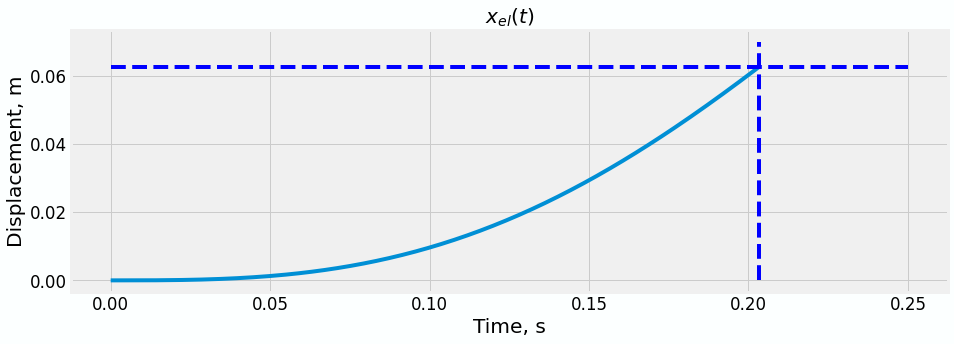

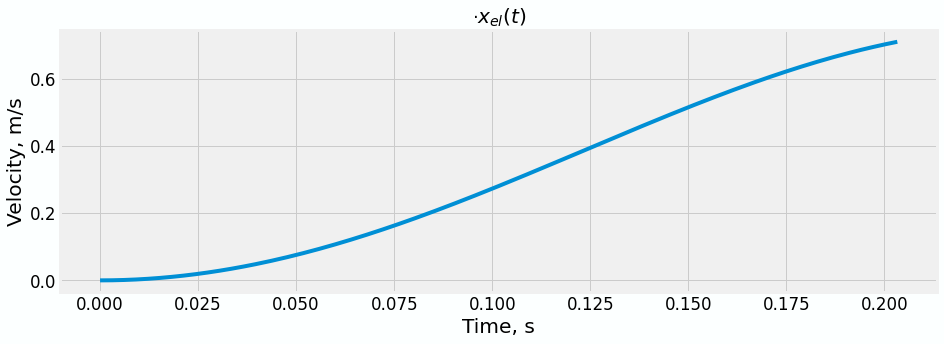

In [ ]:
t_el = linspace( 0.0, t_yield, 201)
x_el = (x_next)(t_el)
v_el = (v_next)(t_el)
# ------------------------------
figure(0)
plot(t_el,x_el,
     (0,0.25),(xy,xy),'--b',
     (t_yield,t_yield),(0,0.0699),'--b')
title("$x_{el}(t)$")
xlabel("Time, s")
ylabel("Displacement, m")
# ------------------------------
figure(1)
plot(t_el,v_el)
title("$\dot x_{el}(t)$")
xlabel("Time, s")
ylabel("Velocity, m/s");

### Preparing for EP response
First, the system state at $t_y$ is the initial condition for the EP response

In [ ]:
x0=x_next(t_yield)
v0=v_next(t_yield)
print(x0, v0)

0.06250000230469434 0.7097432496991541


now, the load must be expressed in function of a *restarted time*,

<center>
    $\tau=t-t_y\;\rightarrow\;t=\tau+t_y\;\rightarrow\;\sin(\omega t)=\sin(\omega\tau+\omega t_y)$
 </center> <center>  
    $\rightarrow\;\sin(\omega t)=\sin(\omega\tau)\cos(\omega t_y)+\cos(\omega\tau)\sin(\omega t_y)$
</center>

In [ ]:
cS = Po*cos(w*t_yield)
cC = Po*sin(w*t_yield)

print(Po*sin(w*0.55), cS*sin(w*(0.55-t_yield))+cC*cos(w*(0.55-t_yield)))

-2999.999999999998 -2999.999999999996


Now we generate the displacement and velocity functions for the yielded phase,
please note that the yielded spring still exerts a constant force $f_y$ on the mass,
and that this fact must be (and it is) taken into account.

In [ ]:
x_next, v_next = resp_yield(mass, damp,    cC,cS,w, -fy, x0,v0)

At this point I must confess that I have already peeked the numerical solution,
hence I know that the velocity at $t=t_1$ is still greater than 0 and I know that the current
solution is valid in the interval $t_y\leq t\leq t_1$.

In [ ]:
t_y1 = linspace(t_yield, t1, 101)
x_y1 = (x_next)(t_y1-t_yield)
v_y1 = (v_next)(t_y1-t_yield)

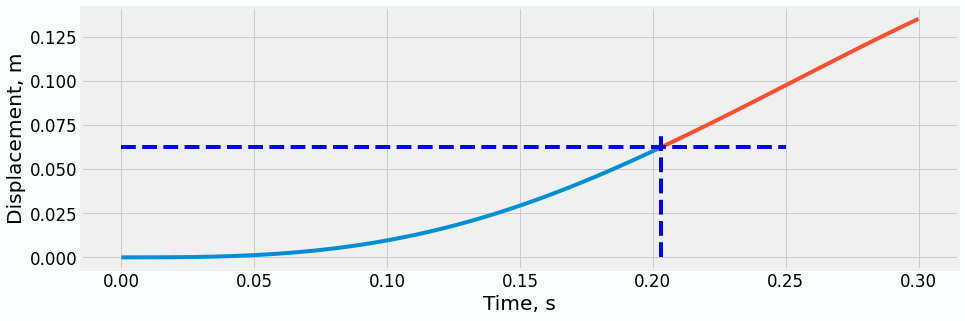

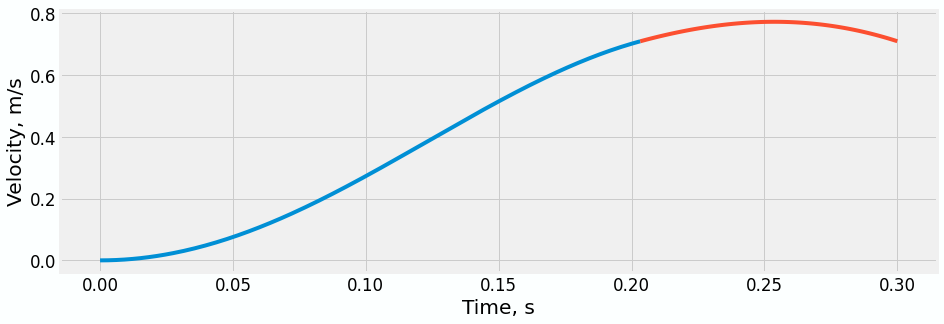

In [ ]:
figure(3)
plot(t_el,x_el, t_y1,x_y1,
     (0,0.25),(xy,xy),'--b',
     (t_yield,t_yield),(0,0.0699),'--b')
xlabel("Time, s")
ylabel("Displacement, m")
# ------------------------------
figure(4)
plot(t_el, v_el,  t_y1, v_y1)
xlabel("Time, s")
ylabel("Velocity, m/s");

In the next phase,  still it is $\dot x> 0$ so that
the spring is still yielding,
but now $p(t)=0$, so we must compute two new state functions,
starting as usual from the initial conditions (note that the yielding
force is still applied)

In [ ]:
x0 = x_next(t1-t_yield)
v0 = v_next(t1-t_yield)
print(x0, v0)
x_next, v_next = resp_yield(mass, damp, 0, 0, w, -fy, x0, v0)

t2 = t1 + bisect( v_next, 0.0, 0, 0.3)
print(t2)
t_y2 = linspace( t1, t2, 101)
x_y2 = (x_next)(t_y2-t1)
v_y2 = (v_next)(t_y2-t1)
print(x_next(t2-t1))

0.13520933022261195 0.7099968785770994
0.5697131395339965
0.22932407805445898


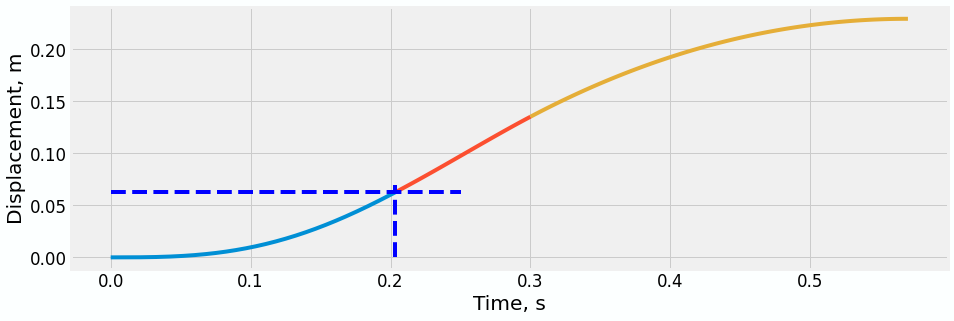

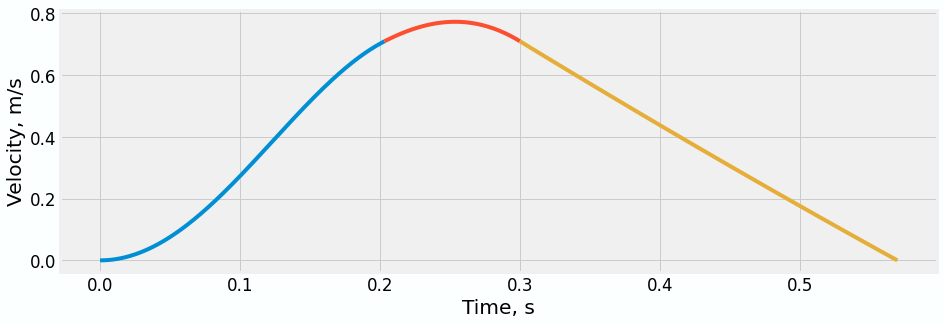

In [ ]:
figure(5)
plot(t_el,x_el, t_y1,x_y1, t_y2, x_y2,
     (0,0.25),(xy,xy),'--b',
     (t_yield,t_yield),(0,0.0699),'--b')
xlabel("Time, s")
ylabel("Displacement, m")
# ------------------------------
figure(6)
plot(t_el, v_el,  t_y1, v_y1, t_y2, v_y2)
xlabel("Time, s")
ylabel("Velocity, m/s");

### Elastic unloading

The only point worth commenting is the constant force
that we apply to our system.

The force-displacement relationship for an EP spring is 

<center>$f_\text{E} = k(x-x_\text{pl})= k x - k (x_\text{max}-x_y)$</center>

taking the negative, constant part of the last expression
into the right member of the equation of equilibrium we have a constant
term, as follows

In [ ]:
x0 = x_next(t2-t1) ; v0 = 0.0
x_next, v_next = resp_elas(mass,damp,k, 0.0,0.0,w, k*x0-fy, x0,v0)
t_e2 = linspace(t2,4.0,201)
x_e2 = (x_next)(t_e2-t2)
v_e2 = (v_next)(t_e2-t2)

now we are ready to plot the whole response

Text(0, 0.5, 'Displacement, m')

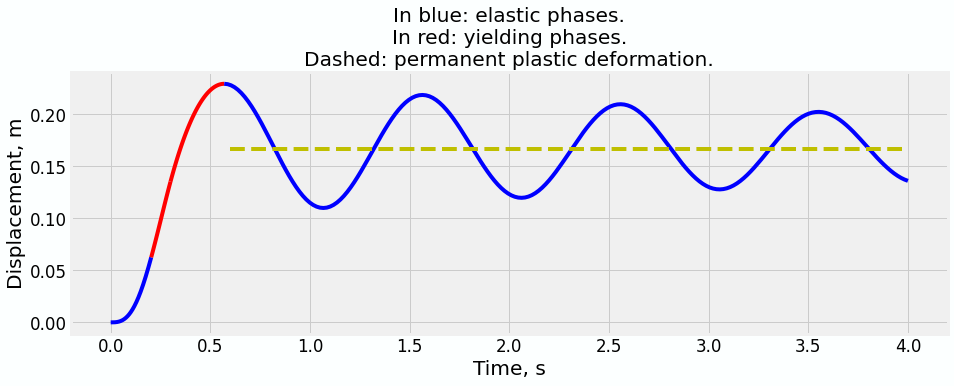

In [ ]:
# ------------------------------
figure(7) ;
plot(t_el, x_el, '-b',
     t_y1, x_y1, '-r',
     t_y2, x_y2, '-r',
     t_e2, x_e2, '-b',
     (0.6, 4.0), (x0-xy, x0-xy), '--y')
title("In blue: elastic phases.\n"+
      "In red: yielding phases.\n"+
      "Dashed: permanent plastic deformation.")
xlabel("Time, s")
ylabel("Displacement, m")

## Numerical solution

First, we need a function that, given the displacement,
the velocity and the total plastic deformation, returns
the stiffness and the new p.d.; this function is defined
in terms of the initial stiffness and the yielding load

In [ ]:
def make_kt(k,fy):
  "make_kt(k,fy) returns a function kt(u,v,up) returning kt, up"
  def kt(u,v,up):
    f=k*(u-up)
    if (-fy)<f<fy:               return k,up
    if fy<=f    and v>0:  up=u-uy;return 0,up
    if fy<=f    and v<=0: up=u-uy;return k,up
    if f<=(-fy) and v<0:  up=u+uy;return 0,up
    else:                 up=u+uy;return k,up
  return kt

### Problem data

In [ ]:
# Exercise from lesson 04
# 
mass = 1000.00       # kilograms
k  =  40000.00       # Newtons per metre
zeta  =   0.03       # zeta is the damping ratio
fy =   2500.00       # yelding force, Newtons
t1 =      0.30       # half-sine impulse duration, seconds
p0 =   6000.00       # half-sine impulse peak value, Newtons
uy =      fy/k       # yelding displacement, metres

### Initialize the algorithm

1. compute the functions that return the load and the tangent sstiffness + plastic deformation
2. compute the damping constant
3. for a given time step, compute all the relevant algorithmic constants, with $\gamma=\frac12$ and
   $\beta=\frac14$

In [ ]:
# using the above constants, define the loading 
t = linspace(0, 4, 801) # dt = 0.005 s
p = where(t<t1, p0*sin(pi*t/t1), 0
         )
# the following function, given the final displacement, the final
# velocity and the initial plastic deformation returns a) the tangent
# stiffness b) the final plastic deformation
kt=make_kt(k,fy) 

# we need the damping coefficient "c", to compute its value from the
# damping ratio we must first compute the undamped natural frequency 
wn=sqrt(k/mass)       # natural frequency of the undamped system
damp=2*mass*wn*zeta         # the damping coefficient

# the time step
h=0.005
# required duration for the response
t_end = 4.0
# the number of time steps to arrive at t_end
nsteps=int((t_end+h/100)/h)+1
# the maximum number of iterations in the Newton-Raphson procedure
maxiters = 30
# using the constant acceleration algorithm
# below we define the relevant algorithmic constants
γ = 0.5 ; β=1./4.
γ_over_β = γ/β
a = mass/(β*h)+damp*γ_over_β
b = 0.5*mass/β+h*damp*(0.5*γ_over_β-1.0)

### System state initialization

and a bit more, in species we create a container, `disp`, to hold the computation results.

In [ ]:
u0, v0, up = 0.0, 0.0, 0.0
disp = []

### Iteration
We iterate over time and, if there is a state change, over the single time step to equilibrate
the unbalanced loadings

In [ ]:
for p0, p1 in zip(p[0:], p[1:]):

    disp.append(u0)

    # advance time, next external load value, etc
    a0 = (p0-damp*v0-k*(u0-up))/mass
    k0, up = kt(u0, v0, up)
    Dp = p1 - p0
    Dp_= Dp + a*v0 + b*a0
    k_ = k0 + γ_over_β*damp/h + mass/(β*h*h)
    # We prepare the machinery for the modified Newton-Raphson algorithm.
    # If we have no state change in the time step,
    # the N-R algorithm is equivalent to the standard procedure
    u_init=u0; v_init=v0 # initial state
    f_spring=k*(u0-up)   # the force in the spring
    DR=Dp_               # the unbalanced force, initially equal to the external load increment
    for j in range(maxiters):
        Du=DR/k_           # the disp increment according to the initial stiffness
        u_next = u_init + Du
        v_next = v_init + γ_over_β*Du/h - γ_over_β*v_init + h*(1.0-0.5*γ_over_β)*a0
                           # we are interested in the total plastic elongation
        oops,up=kt(u_next,v_next,up)
                           # because we need the spring force at the end of the time step
        f_spring_next=k*(u_next-up)
                           # so that we can compute the fraction of the incremental force
                           # that's equilibrated at the end of the time step
        df=f_spring_next-f_spring+(k_-k0)*Du
                           # and finally the incremental forces still unbalanced the end of the time step
        DR=DR-df
                           # finish updating the system state
        u_init=u_next; v_init=v_next; f_spring=f_spring_next
                           # if the unbalanced load is small enough (the criteria used in practical
                           # programs are energy based) exit the loop - if we
                           # have no plasticization/unloading DR==0 at the end of the first iteration
        if abs(DR)<fy*1E-6: break
    # now the load increment is balanced by the spring force and increments in inertial and damping forces,
    # we need to compute the full state at the end of the time step, and to change all denominations
    # to reflect the fact that we are starting a new time step.
    Du=u_init-u0
    Dv=γ*Du/(β*h)-γ*v0/β+h*(1.0-0.5*γ_over_β)*a0
    u0 = u0+Du ; v0 = v0+Dv
disp.append(u0)

### Plotting our results

we plot red crosses for the numericaly computed response and a continuous line for the results
of the analytical integration of the equation of motion.

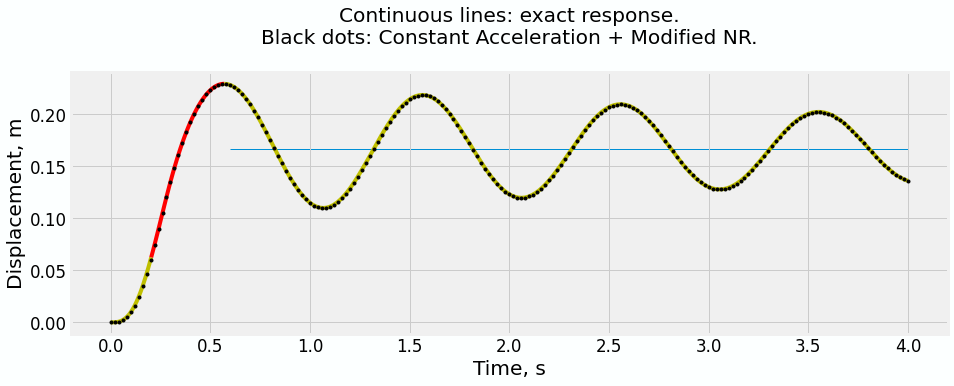

In [ ]:
figure(8)
plot(t[::4],disp[::4],'.k', zorder=5)
plot(t_el, x_el, '-y',
     t_y1, x_y1, '-r',
     t_y2, x_y2, '-r',
     t_e2, x_e2, '-y',)
plot((0.6, 4.0), (x0-xy, x0-xy), lw=1, zorder=-1)
title("Continuous lines: exact response.\n"+
      "Black dots: Constant Acceleration + Modified NR.\n")
xlabel("Time, s")
ylabel("Displacement, m");